<a href="https://colab.research.google.com/github/seunghwan-cha/seunghwancha/blob/main/friends_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요 패키지 import

In [35]:
import json
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import Text
import collections
from keras.layers.core import Dense, SpatialDropout1D 
from keras.layers.convolutional import Conv1D 
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences 
from keras.utils import np_utils 
from sklearn.model_selection import train_test_split

불용어 리스트 다운 및 어간추출기 stemmer 정의

In [36]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


불용어 리스트

In [37]:
from nltk.corpus import stopwords
print (stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

json 파일 load 및 전처리, 불용어 제거, 어간추출 진행

In [69]:
with open('friends_train.json') as json_file:
    json_train = json.load(json_file)
with open('friends_test.json') as json_file:
    json_test = json.load(json_file)
with open('friends_dev.json') as json_file:
    json_dev = json.load(json_file)

def cleaning(str):
    replaceAll = str
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)
    no_capitals = only_english.lower().split()
    no_stops = [word for word in no_capitals if not word in stops]
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    return ' '.join(stemmer_words)

i = 0
train_data=[]
for rows in json_train:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_test:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_dev:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])

In [67]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

품사태깅 진행

In [70]:
cnt = 0
tagged = []
counter = collections.Counter()
for d in train_data:
    cnt = cnt + 1
    if cnt % 1000 == 0:
        print(cnt)
    words = pos_tag(word_tokenize(d[0]))
    for t in words:
        word = "/".join(t)
        tagged.append(word)
        counter[word] += 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


임베딩 진행

In [71]:
VOCAB_SIZE = 5000
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

라벨을 int값으로 바꿔주고 word2index를 이용 숫자벡터로 전환

In [72]:
def labeltoint(str):
    return {'non-neutral': 0,
             'neutral': 1, 
             'joy': 2,
             'sadness': 3,
             'fear': 4,
             'anger': 5,
             'surprise': 6,
             'disgust': 7}[str]

xs, ys = [], []
cnt = 0
maxlen = 0
for d in train_data:
    cnt = cnt + 1
    ys.append(labeltoint(d[1]))
    if cnt % 1000 == 0:
        print(cnt)
    ang = pos_tag(word_tokenize(d[0]))
    words=[]
    for t in ang:
        words.append("/".join(t))
    if len(words) > maxlen: 
        maxlen = len(words)
    wids = [word2index[word] for word in words]
    xs.append(wids)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [81]:
X = pad_sequences(xs, maxlen=maxlen) 
Y = np_utils.to_categorical(ys)
 
EMBED_SIZE = 100 
NUM_FILTERS = 256 
NUM_WORDS = 3 
BATCH_SIZE = 64 
NUM_EPOCHS = 20

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=50)
model = Sequential() 
model.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen)) 
model.add(SpatialDropout1D(0.2)) 
#model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu")) 
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
#model.add(GlobalMaxPooling1D()) 
model.add(Dense(8, activation="softmax")) 
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) 

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test)) 

Epoch 1/20
159/159 [==============================] - 20s 109ms/step - loss: 1.7031 - accuracy: 0.4280 - val_loss: 1.5615 - val_accuracy: 0.4505
Epoch 2/20
159/159 [==============================] - 17s 106ms/step - loss: 1.5102 - accuracy: 0.4637 - val_loss: 1.4836 - val_accuracy: 0.4725
Epoch 3/20
159/159 [==============================] - 17s 109ms/step - loss: 1.2989 - accuracy: 0.5471 - val_loss: 1.5279 - val_accuracy: 0.4383
Epoch 4/20
159/159 [==============================] - 17s 107ms/step - loss: 1.1754 - accuracy: 0.5788 - val_loss: 1.5795 - val_accuracy: 0.4535
Epoch 5/20
159/159 [==============================] - 18s 116ms/step - loss: 1.0340 - accuracy: 0.6403 - val_loss: 1.6448 - val_accuracy: 0.4590
Epoch 6/20
159/159 [==============================] - 17s 108ms/step - loss: 0.9295 - accuracy: 0.6666 - val_loss: 1.7387 - val_accuracy: 0.4335
Epoch 7/20
159/159 [==============================] - 17s 108ms/step - loss: 0.8824 - accuracy: 0.6925 - val_loss: 1.8119 - val_ac

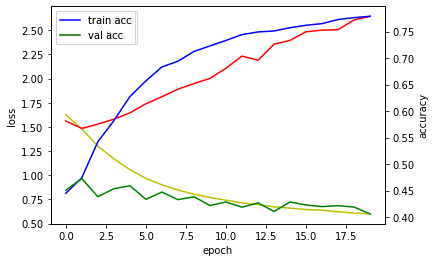

In [82]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [84]:
def inttolabel(idx):
    return {0:'non-neutral',
             1:'neutral', 
             2:'joy',
             3:'sadness',
             4:'fear',
             5:'anger',
             6:'surprise',
             7:'disgust'}[idx]

def predict(text): 
    aa = pos_tag(word_tokenize(text))
    pp = []
    for t in aa:
        pp.append("/".join(t))
    wids = [word2index[word] for word in pp]
    x_predict = pad_sequences([wids], maxlen=maxlen) 
    y_predict = model.predict(x_predict) 
    c = 0
    cnt = 0
    for y in y_predict[0]:
        if c < y:
            c = y
            ans = cnt
        cnt += 1
    ans = inttolabel(ans)
    return ans;

In [91]:
with open('en_data.csv', 'r', newline='') as csvfile:
    df = pd.read_csv(csvfile)
cnt = 0
dap = []
for i in df['utterance']:
    cnt+=1
    if cnt % 1000 == 0 : 
        print(cnt)
    dap.append(predict(i))
result = [['Id','Predicted']]
cnt = -1

for i in dap:
    cnt += 1
    result.append([cnt, i])
dataframe = pd.DataFrame(result)
dataframe.to_csv("test.csv", header=False, index=False)

1000


In [92]:
ans = predict('i love it')
print(ans)

neutral


In [88]:
import pandas as pd

df_test=pd.read_csv("en_data.csv",header=0, delimiter=",")


df_test.head()


,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!
